In [1]:
!wget -nc -O cdc_cases_deaths.csv https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/b46b0e232fb30e566763505ecc6dfaa85362ed28/data/cdc_cases_deaths.csv
!wget -nc -O census_population.csv https://gitlab.com/-/snippets/2528408/raw/main/census_population.csv

--2023-10-31 00:44:31--  https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/b46b0e232fb30e566763505ecc6dfaa85362ed28/data/cdc_cases_deaths.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1653100 (1.6M) [text/plain]
Saving to: ‘cdc_cases_deaths.csv’

cdc_cases_deaths.cs 100%[===================>]   1.58M  --.-KB/s    in 0.05s   

2023-10-31 00:44:32 (34.6 MB/s) - ‘cdc_cases_deaths.csv’ saved [1653100/1653100]

--2023-10-31 00:44:32--  https://gitlab.com/-/snippets/2528408/raw/main/census_population.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1182 (1.2K) [text/plain]


In [2]:
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import requests
from sklearn.cluster import KMeans
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv(
    "cdc_cases_deaths.csv",
    usecols=['submission_date','state', 'conf_cases','conf_death','consent_cases', 'consent_deaths'],
    parse_dates=['submission_date']
)
df = df[(df["conf_cases"] > 0) & (df["conf_death"] > 0) & (df["consent_cases"] == "Agree") & (df["consent_deaths"] == "Agree")]
df = df.drop(columns=['consent_cases', 'consent_deaths'])
df = df[(df['submission_date'] >= '2020-03-25') & (df['submission_date'] <= '2020-12-25') ]
df = df[df['submission_date'].dt.strftime('%d').isin(['01','05','10','15','20','25'])]
df = df.rename(columns={"conf_cases": "cases", "conf_death": "deaths"})
df['cases'] = df['cases'].astype(int)
df['deaths'] = df['deaths'].astype(int)
df['recovery'] = df['cases']-df['deaths']

adj_cdf = df.drop(columns=['state'])
adj_cdf = adj_cdf.groupby(['submission_date']).sum()
if os.path.isfile("census_population.csv") is False:
  population_df = pd.DataFrame(columns=['submission_date','population'])
  for index, row in adj_cdf.iterrows():
    response = requests.get('https://www.census.gov/popclock/data/population.php/us?date={0}'.format(index.strftime('%Y%m%d')))
    content = response.content.decode('utf-8')
    # We were unable to retrieve your data in a timely manner.
    # https://www.census.gov/popclock/data/population.php/us?date=20200305
    if "unable to retrieve" in content:
        content = content.split("'").pop()
    deserialized = json.loads(content)
    row = [index.strftime('%m/%d/%Y'),int(deserialized['us']['population'])]
    population_df = pd.concat([population_df, pd.DataFrame([row], columns=population_df.columns)], ignore_index=True)
  population_df.to_csv("census_population.csv", index=False)
else:
  population_df = pd.read_csv(
    "census_population.csv",
    usecols=['submission_date', 'population'],
    parse_dates=['submission_date'],
    index_col='submission_date'
  )
adj_cdf = adj_cdf.merge(population_df, how='right', on='submission_date')
adj_cdf.index.names = ['date']
adj_cdf.index = adj_cdf.index.strftime('%m/%d/%Y')
adj_cdf.to_csv("country_subset.csv")
pd.DataFrame(adj_cdf).style.to_latex('country_subset.tex')
adj_cdf.index = pd.to_datetime(adj_cdf.index)

adj_sdf = df.sort_values('submission_date')
adj_sdf = adj_sdf.drop(columns=['submission_date'])
adj_sdf = adj_sdf.groupby(['state']).nth(-1)
adj_sdf = adj_sdf.rename(index={'NYC': 'NY'})
adj_sdf = adj_sdf.drop(index=['MP'])
adj_sdf.to_csv("state_subset.csv")
pd.DataFrame(adj_sdf).style.to_latex('state_subset.tex')

adj_cdf

cases  deaths  recovery  population
date                                             
2020-03-25      504       1       503   329433166
2020-04-01     1584       9      1575   329459499
2020-04-05     2585      31      2554   329476690
2020-04-10     3908      74      3834   329498178
2020-04-15   130619    7672    122947   329519667
2020-04-20   326443   18652    307791   329541155
2020-04-25   436615   25705    410910   329562644
2020-05-01   515576   31842    483734   329588430
2020-05-05   561470   34182    527288   329606219
2020-05-10   625946   38446    587500   329628455
2020-05-15   680173   42034    638139   329650692
2020-05-20   732398   44858    687540   329672928
2020-05-25   784045   47415    736630   329695164
2020-06-01   849940   50655    799285   329726295
2020-06-05   886338   52305    834033   329746456
2020-06-10   929645   54055    875590   329771658
2020-06-15   975503   55495    920008   329796860
2020-06-20  1038759   57050    981709   329822061
2020-06-25  1104655   58432   1046223   329847263
2020-07-01  1205765   60491   1145274   329877505
2020-07-05  1284999   61192   1223807   329899443
2020-07-10  1388488   62810   1325678   329926866
2020-07-15  1503448   64192   1439256   329954289
2020-07-20  1626670   65743   1560927   329981711
2020-07-25  1756264   68034   1688230   330009134
2020-08-01  1925549   70771   1854778   330047526
2020-08-05  2000485   72072   1928413   330069263
2020-08-10  2102576   73367   2029209   330096434
2020-08-15  2197800   75444   2122356   330123605
2020-08-20  2276011   77204   2198807   330150776
2020-08-25  2358032   78780   2279252   330177947
2020-09-01  2475466   81236   2394230   330215986
2020-09-05  2550763   82689   2468074   330238125
2020-09-10  2616739   83918   2532821   330265798
2020-09-15  2699039   85415   2613624   330293471
2020-09-20  2792140   86785   2705355   330321145
2020-09-25  2879397   88414   2790983   330348818
2020-10-01  2988233   90009   2898224   330382026
2020-10-05  3066371   90909   2975462   330400989
2020-10-10  3182475   92432   3090043   330424693
2020-10-15  3305166   93699   3211467   330448397
2020-10-20  3440605   95094   3345511   330472101
2020-10-25  3606521   96895   3509626   330495805
2020-11-01  3867726   99417   3768309   330528990
2020-11-05  4052847  101196   3951651   330546051
2020-11-10  4346956  103238   4243718   330567378
2020-11-15  4694410  105859   4588551   330588705
2020-11-20  5075047  109352   4965695   330610031
2020-11-25  5420314  112452   5307862   330631358
2020-12-01  5834653  115881   5718772   330656950
2020-12-05  6170432  119987   6050445   330671932
2020-12-10  6574954  124411   6450543   330690661
2020-12-15  6997693  128753   6868940   330709389
2020-12-20  7386553  133790   7252763   330728117
2020-12-25  7708482  138161   7570321   330746845

In [4]:
def plot_params_df(dataframe, filename):
  fig, axes = plt.subplots(nrows=2, ncols=2)
  dataframe['cases'].plot(ax=axes[0,0], grid=True, cmap="gist_gray")
  axes[0,0].set_title('Cases')
  dataframe['deaths'].plot(ax=axes[0,1], grid=True, cmap="gist_gray")
  axes[0,1].set_title('Deaths')
  dataframe['recovery'].plot(ax=axes[1,0], grid=True, cmap="gist_gray")
  axes[1,0].set_title('Recovery')
  dataframe['population'].plot(ax=axes[1,1], grid=True, cmap="gist_gray")
  axes[1,1].set_title('Population')
  for i in range(0,2):
    for j in range(0,2):
      axes[i,j].xaxis.set_ticks(dataframe.index[::11])
      axes[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
      axes[i,j].set_xlabel('')
  plt.tight_layout()
  plt.savefig(filename + '.pdf')
def plot_param_dfs(param, filename):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
  dataframes = {
      0: {'df':diff_cdf, 'title': param.title() + ' discrete difference'},
      1: {'df':drd_cdf, 'title': param.title() +' nth root'}
  }
  for i in dataframes:
    dataframes[i]['df'][param].plot(ax=axes[i], grid=True, cmap="gray")
    axes[i].set_title(dataframes[i]['title'])
    axes[i].xaxis.set_ticks(dataframes[i]['df'].index[::10])
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axes[i].set_xlabel('')
  plt.tight_layout()
  plt.savefig(filename + '.pdf')

In [5]:
plot_params_df(adj_cdf, 'country_dataset_adj')

<Axes: xlabel='date'>

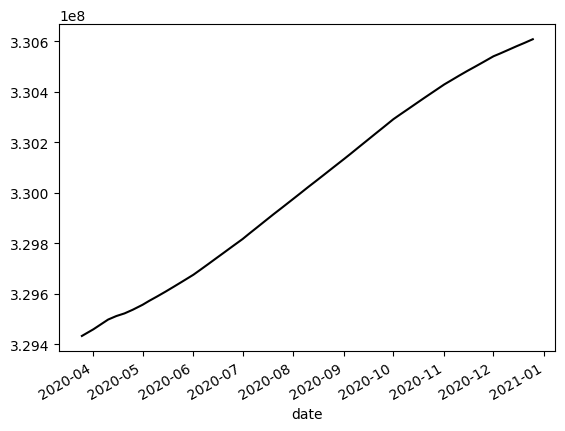

In [6]:
adj_cdf['p_d'] = adj_cdf['population'] - adj_cdf['deaths']
adj_cdf['p_d'].plot(cmap="gray")

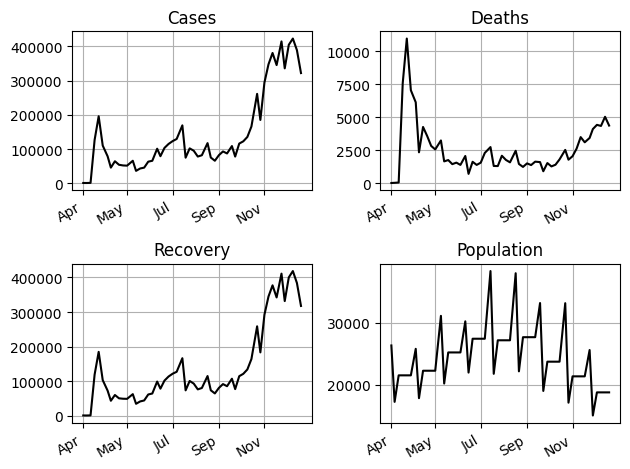

In [7]:
diff_cdf = adj_cdf.diff().iloc[1:, :]
plot_params_df(diff_cdf, 'country_dataset_diff')

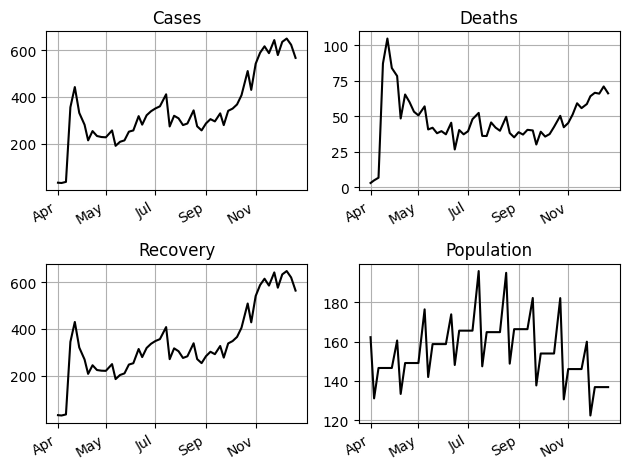

In [8]:
drd_cdf = diff_cdf.copy()
drd_cdf['cases'] = drd_cdf['cases'] ** (1/2)
drd_cdf['deaths'] = drd_cdf['deaths'] ** (1/2)
drd_cdf['recovery'] = drd_cdf['recovery'] ** (1/2)
drd_cdf['population'] = drd_cdf['population'] ** (1/2)
plot_params_df(drd_cdf, 'country_dataset_rdd')

In [9]:
plot_param_dfs('recovery', 'country_recovery')

In [10]:
plot_param_dfs('population', 'country_population')

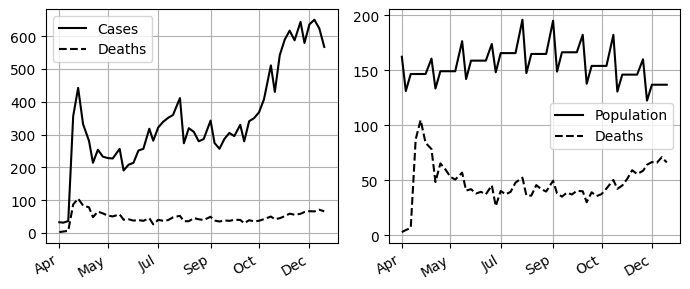

In [11]:
linestyle = ['-k','--k']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
corr = {
    0: {'y':['cases','deaths'], 'legend': ['Cases','Deaths']},
    1: {'y':['population', 'deaths'], 'legend': ['Population', 'Deaths']}
}
for i in range(0,2):
  drd_cdf.plot(y=corr[i]['y'], ax=axes[i], style=linestyle, grid=True)
  axes[i].xaxis.set_ticks(drd_cdf.index[::10])
  axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  axes[i].set_xlabel('')
  axes[i].legend(corr[i]['legend'])
plt.tight_layout()
plt.savefig('country_charts.pdf')

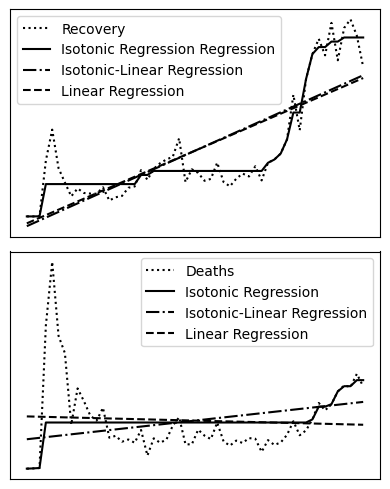

In [12]:
linestyle = [':k','-k','-.k','--k']
ir = IsotonicRegression()
lr = LinearRegression()
r_cdf = pd.DataFrame(data={'Recovery': diff_cdf['recovery'].to_list()})
ir.fit(r_cdf.index.to_numpy()[:, None], r_cdf.Recovery)
r_cdf['IsotonicRegression'] = ir.predict(r_cdf.index.to_numpy()[:, None])
lr.fit(r_cdf.index.to_numpy()[:, None], r_cdf.IsotonicRegression)
r_cdf['LinearOnIsotonicFitRegression'] = lr.predict(r_cdf.index.to_numpy()[:, None])
lr.fit(r_cdf.index.to_numpy()[:, None], r_cdf.Recovery)
r_cdf['LinearRegression'] = lr.predict(r_cdf.index.to_numpy()[:, None])
d_ir = IsotonicRegression()
d_lr = LinearRegression()
d_cdf = pd.DataFrame(data={'Deaths': diff_cdf['deaths'].to_list()})
d_ir.fit(d_cdf.index.to_numpy()[:, None], d_cdf.Deaths)
d_cdf['IsotonicRegression'] = d_ir.predict(d_cdf.index.to_numpy()[:, None])
d_lr.fit(d_cdf.index.to_numpy()[:, None], d_cdf.IsotonicRegression)
d_cdf['LinearOnIsotonicFitRegression'] = d_lr.predict(d_cdf.index.to_numpy()[:, None])
d_lr.fit(d_cdf.index.to_numpy()[:, None], d_cdf.Deaths)
d_cdf['LinearRegression'] = d_lr.predict(d_cdf.index.to_numpy()[:, None])
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,5))
dataframes = {
    0: {'df':r_cdf, 'name': 'Recovery', 'legend': [
        'Recovery',
        'Isotonic Regression Regression',
        'Isotonic-Linear Regression',
        'Linear Regression'
    ]},
    1: {'df':d_cdf, 'name': 'Deaths', 'legend': [
        'Deaths',
        'Isotonic Regression',
        'Isotonic-Linear Regression',
        'Linear Regression'
    ]}
}
for i in range(0,2):
  dataframes[i]['df'].plot(
      y=[
          dataframes[i]['name'],
          'IsotonicRegression',
          'LinearOnIsotonicFitRegression',
          'LinearRegression'
      ],
      ax=axes[i],
      style=linestyle
  )
  axes[i].xaxis.set_ticks([])
  axes[i].yaxis.set_ticks([])
  axes[i].legend(dataframes[i]['legend'])
plt.tight_layout()
plt.savefig('country_regressions.pdf')

In [13]:
class_sdf = adj_sdf.copy()
class_sdf['deaths_class'] = class_sdf.apply(lambda row: 1 if row['deaths'] > class_sdf['deaths'].mean() else 0, axis=1)
class_sdf['recovery_class'] = class_sdf.apply(lambda row: 1 if row['recovery'] > class_sdf['recovery'].mean() else 0, axis=1)
class_sdf.sort_index(inplace=True)
class_sdf.rename(
    columns={
    'cases': 'ConfirmedCases',
    'deaths': 'ConfirmedDeaths',
    'recovery': 'Recovery',
    'deaths_class': 'DeathsClass',
    'recovery_class': 'RecoveryClass',
}, inplace=True)
pd.DataFrame(class_sdf).style.to_latex("states_classified.tex")
class_sdf

ConfirmedCases  ConfirmedDeaths  Recovery  DeathsClass  RecoveryClass
state                                                                       
AL             277754             4096    273658            0              0
AZ             465013             7635    457378            1              1
CO             308907             3948    304959            0              1
CT             162449             4686    157763            0              0
DE              51486              791     50695            0              0
GA             537079             9656    527423            1              1
ID             112397             1191    111206            0              0
IL             930849            15799    915050            1              1
KY             202044             2312    199732            0              0
MA             328307            11706    316601            1              1
ME              18517              314     18203            0              0
MI             469928            11775    458153            1              1
MS             143736             3718    140018            0              0
MT              78929              916     78013            0              0
NC             467480             6152    461328            1              1
NY             365473            20151    345322            1              1
OH             590630             7687    582943            1              1
OK             229462             2218    227244            0              0
OR             105998             1407    104591            0              0
PR              68461             1187     67274            0              0
SC             263392             4662    258730            0              0
TN             485728             5646    480082            1              1
UT             260589             1182    259407            0              0
VA             279153             4272    274881            0              0
WI             467899             4679    463220            0              1
WY              36700              373     36327            0              0

In [14]:
!pip install kaleido
gray_colorscale=[
    [0.00, "rgb(0, 0, 0)"],
    [0.05, "rgb(10, 10, 10)"],
    [0.10, "rgb(20, 20, 20)"],
    [0.15, "rgb(30, 30, 30)"],
    [0.20, "rgb(40, 40, 40)"],
    [0.25, "rgb(50, 50, 50)"],
    [0.30, "rgb(60, 60, 60)"],
    [0.35, "rgb(70, 70, 70)"],
    [0.40, "rgb(80, 80, 80)"],
    [0.45, "rgb(90, 90, 90)"],
    [0.50, "rgb(100, 100, 100)"],
    [0.55, "rgb(110, 110, 110)"],
    [0.60, "rgb(120, 120, 120)"],
    [0.65, "rgb(130, 130, 130)"],
    [0.70, "rgb(140, 140, 140)"],
    [0.75, "rgb(150, 150, 150)"],
    [0.80, "rgb(160, 160, 160)"],
    [0.85, "rgb(170, 170, 170)"],
    [0.90, "rgb(180, 180, 180)"],
    [0.95, "rgb(190, 190, 190)"],
    [1.00, "rgb(200, 200, 200)"]
]
fig = go.Figure(data=go.Choropleth(
  locations=adj_sdf.index,
  z=adj_sdf['deaths'].astype(int),
  locationmode='USA-states',
  colorscale=gray_colorscale,
  colorbar_title='Deaths',
  showlegend=False
))
fig.update_layout(
  autosize=True,
  geo_scope='usa',
  geo_landcolor = "rgb(240,240,240)"
)
fig.show()
fig.write_image('states_deaths.pdf')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [15]:
fig = go.Figure(data=go.Choropleth(
  locations=adj_sdf.index,
  z=adj_sdf['recovery'].astype(float),
  locationmode='USA-states',
  colorscale=gray_colorscale,
  colorbar_title='Rate',
))
fig.update_layout(
  autosize=True,
  geo_scope='usa',
  geo_landcolor = "rgb(240,240,240)"
)
fig.show()
fig.write_image('states_recovery.pdf')

In [16]:
samples = []
for x in adj_sdf.index:
  state = adj_sdf[(adj_sdf.index == x)]
  samples.append((state.deaths.values[0], state.cases.values[0]))
X = np.array(samples)
n_clusters = 2
clusterer = KMeans(n_clusters=n_clusters, n_init=10)
cluster_labels = clusterer.fit_predict(X)
for i, x in enumerate(cluster_labels):
  marker = 'o' if x == 0 else 'x'
  plt.scatter(X[:, 0][i], X[:, 1][i], marker=marker, c="gray", alpha=0.72)
for x in adj_sdf.index:
  plt.annotate(x, xy=(
    adj_sdf[(adj_sdf.index == x)].deaths.values[0],
    adj_sdf[(adj_sdf.index == x)].cases.values[0]
  ))
plt.xlabel('Deaths')
plt.ylabel('Cases')
plt.xticks([])
plt.yticks([])
plt.savefig('states_cluster.pdf')
plt.axis("tight")
plt.show()

In [17]:
!tar -czvf appendix.tgz *.pdf *.csv *.tex

country_charts.pdf
country_dataset_adj.pdf
country_dataset_diff.pdf
country_dataset_rdd.pdf
country_population.pdf
country_recovery.pdf
country_regressions.pdf
states_cluster.pdf
states_deaths.pdf
states_recovery.pdf
cdc_cases_deaths.csv
census_population.csv
country_subset.csv
state_subset.csv
country_subset.tex
states_classified.tex
state_subset.tex
